## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [400]:
!pip install plotly
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


/home/rakeshpc/.local/lib/python3.8/site-packages/spacy/util.py:833: UserWarning:

[W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.6). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate

[nltk_data] Downloading package punkt to /home/rakeshpc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rakeshpc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [401]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [402]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [403]:
# Inspect the dataframe to understand the given data.
df.shape


(78313, 22)

In [404]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [405]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [406]:
df['_source.company_public_response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response    2
Company believes complaint relates to a discontinued policy or procedure                           1
Company chooses not to provide a public response                                                   1
Name: _source.company_public_response, dtype: int64

In [407]:
df['_source.sub_issue'].value_counts()

Credit card company isn't resolving a dispute about a purchase on your statement    2904
Deposits and withdrawals                                                            2759
Company closed your account                                                         2020
Problem using a debit or ATM card                                                   1613
Card was charged for something you did not purchase with the card                   1056
                                                                                    ... 
Problem with additional add-on products or services purchased with the loan            1
Receiving unwanted marketing/advertising                                               1
Report shared with employer w/o consent                                                1
Problem cancelling or closing account                                                  1
Account terms and changes                                                              1
Name: _source.sub_iss

In [408]:
df['_source.sub_product'].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64

In [409]:
df['_source.consumer_consent_provided'].value_counts()

N/A                     42847
Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: _source.consumer_consent_provided, dtype: int64

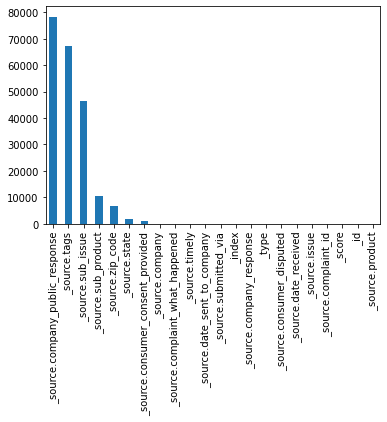

In [410]:
df.isna().sum().sort_values(ascending=False).plot.bar()
plt.show()

## Above we see which all columns are having null about the column names and its data type and also the opportunity where we can correct the data

In [411]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

# Basically we are interested in what is the complain and what is the complaint type

In [412]:
#Basically we are interested in what is the complain and what is the complaint type
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'product','_source.sub_product':'sub_product'}, inplace=True)

In [413]:
#Assign nan in place of blanks in the complaints column
# lets replace empty complain with nan value
df[df['complaints_what_happened']==''] = np.nan
df.complaints_what_happened.isnull().sum()

57241

In [414]:
#Remove all rows where complaints column is nan
df = df[~df['complaints_what_happened'].isnull()]
df.complaints_what_happened.isnull().sum()

0

In [415]:
#Combining product and sub product for creating a new column 
df['sub_product_category'] = df['product'] + '+' + df['sub_product']
df = df.drop(['product','sub_product'],axis= 1)
df.head()
df = df[['complaints_what_happened','sub_product_category']]

In [416]:
df.shape

(21072, 2)

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   complaints_what_happened  21072 non-null  object
 1   sub_product_category      18963 non-null  object
dtypes: object(2)
memory usage: 493.9+ KB


In [418]:
df.head()

,complaints_what_happened,sub_product_category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [419]:

def clean_text_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text.strip()


In [420]:
# performing the cleaning
df['complaints'] = df['complaints_what_happened'].apply(clean_text_data)
df.head()

,complaints_what_happened,sub_product_category,complaints
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,i upgraded my card in and was told by the agen...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,my grand son give me check for i deposit it in...


In [421]:
df.shape

(21072, 3)

In [422]:
#Write your function to Lemmatize the texts
def lemmatization_text_data(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str


In [423]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemma'] =  df.complaints.apply(lambda x: lemmatization_text_data(x))
df.head()

,complaints_what_happened,sub_product_category,complaints,lemma
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [424]:
df_clean = df[['complaints','lemma']]

In [425]:
df_clean.head()

,complaints,lemma
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [426]:
df_clean.shape

(21072, 2)

In [427]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_pos_tags(x['lemma']), axis=1)


/tmp/ipykernel_5209/2471038126.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [428]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemma,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,wednesday visa credit card provider claim purc...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




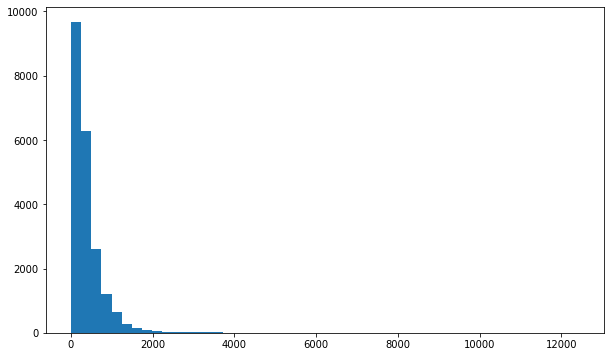

In [429]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [430]:
!pip install wordcloud
!python3 -m pip install --upgrade Pillow==10.1.0

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION:

In [431]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

AttributeError: 'ImageDraw' object has no attribute 'textbbox'

In [440]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,wednesday visa credit card provider claim purc...,wednesday visa credit card provider claim purc...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


In [441]:
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [442]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_unigrams

[('chase', 73619),
 ('account', 47786),
 ('credit', 32844),
 ('card', 30562),
 ('bank', 28136),
 ('payment', 21366),
 ('time', 16316),
 ('day', 13328),
 ('charge', 12139),
 ('money', 12006),
 ('loan', 11027),
 ('check', 10431),
 ('letter', 9706),
 ('information', 9688),
 ('fee', 9010),
 ('transaction', 8671),
 ('number', 8658),
 ('month', 8622),
 ('year', 8472),
 ('mortgage', 8215),
 ('customer', 8207),
 ('balance', 7798),
 ('service', 7683),
 ('company', 7663),
 ('phone', 7599),
 ('fraud', 7152),
 ('report', 7083),
 ('fund', 7043),
 ('claim', 6773),
 ('business', 5644)]

In [443]:
#Print the top 10 words in the unigram frequency
top_30_unigrams[:10]

[('chase', 73619),
 ('account', 47786),
 ('credit', 32844),
 ('card', 30562),
 ('bank', 28136),
 ('payment', 21366),
 ('time', 16316),
 ('day', 13328),
 ('charge', 12139),
 ('money', 12006)]

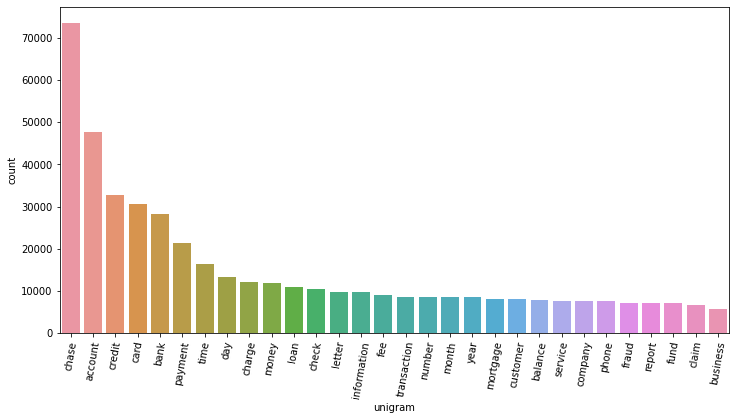

In [444]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [445]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_bigrams

[('credit card', 12939),
 ('chase bank', 12276),
 ('account chase', 4710),
 ('credit report', 3892),
 ('chase credit', 3831),
 ('checking account', 3555),
 ('chase account', 3358),
 ('customer service', 3097),
 ('bank account', 2966),
 ('account account', 2742),
 ('morgan chase', 2506),
 ('card chase', 2475),
 ('debit card', 2056),
 ('chase card', 1999),
 ('card account', 1764),
 ('credit score', 1717),
 ('payment payment', 1688),
 ('chase chase', 1665),
 ('account credit', 1625),
 ('letter chase', 1482),
 ('money account', 1446),
 ('payment chase', 1417),
 ('chase customer', 1397),
 ('bank chase', 1355),
 ('credit bureau', 1317),
 ('business day', 1274),
 ('phone number', 1271),
 ('account number', 1239),
 ('charge chase', 1206),
 ('card card', 1198)]

In [446]:
#Print the top 10 words in the bigram frequency
top_30_bigrams[:10]

[('credit card', 12939),
 ('chase bank', 12276),
 ('account chase', 4710),
 ('credit report', 3892),
 ('chase credit', 3831),
 ('checking account', 3555),
 ('chase account', 3358),
 ('customer service', 3097),
 ('bank account', 2966),
 ('account account', 2742)]

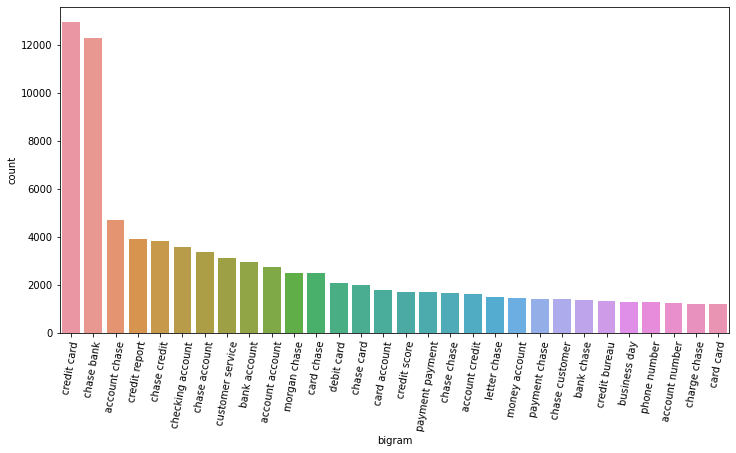

In [447]:
#Plot graph for the top 30 words in the bigram frequency
df1 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['bigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [448]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)
top_30_trigrams

[('chase credit card', 2635),
 ('credit card chase', 1163),
 ('credit card account', 1108),
 ('account chase bank', 1041),
 ('credit card company', 1004),
 ('chase bank account', 957),
 ('morgan chase bank', 706),
 ('chase customer service', 640),
 ('checking account chase', 619),
 ('jp morgan chase', 560),
 ('inquiry credit report', 549),
 ('credit card credit', 539),
 ('chase bank credit', 534),
 ('chase checking account', 516),
 ('chase bank chase', 460),
 ('card chase bank', 455),
 ('account credit card', 451),
 ('card credit card', 428),
 ('bank credit card', 409),
 ('bank chase bank', 399),
 ('credit reporting agency', 399),
 ('account chase account', 396),
 ('credit report credit', 371),
 ('charge credit card', 368),
 ('account credit report', 355),
 ('customer service representative', 347),
 ('credit card payment', 338),
 ('credit report chase', 329),
 ('credit reporting act', 323),
 ('chase account chase', 298)]

In [449]:
#Print the top 10 words in the trigram frequency
top_30_trigrams[:10]

[('chase credit card', 2635),
 ('credit card chase', 1163),
 ('credit card account', 1108),
 ('account chase bank', 1041),
 ('credit card company', 1004),
 ('chase bank account', 957),
 ('morgan chase bank', 706),
 ('chase customer service', 640),
 ('checking account chase', 619),
 ('jp morgan chase', 560)]

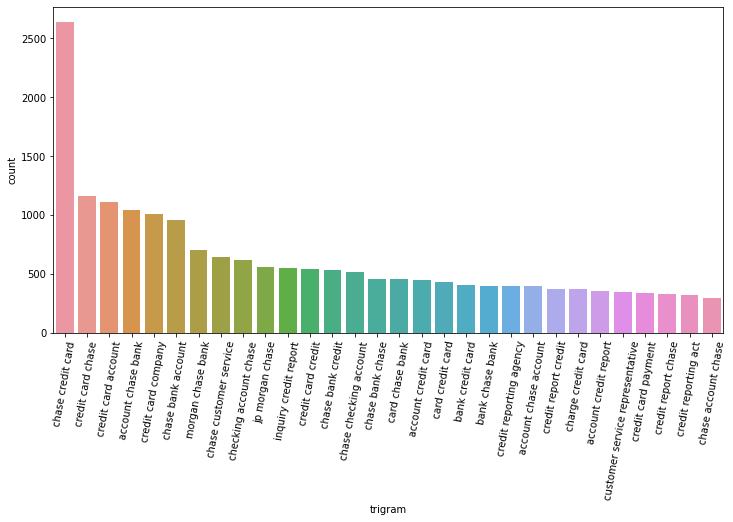

In [450]:
#Plot graph for the top 30 words in the trigram frequency
df1 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['trigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [451]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [452]:
#All masked texts has been removed
df_clean

,complaints,lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,wednesday visa credit card provider claim purc...,wednesday visa credit card provider claim purc...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


In [453]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [454]:
#Write your code here to initialise the TfidfVectorizer 
tf_idf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [455]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = tf_idf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [456]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [457]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [458]:
nmf_model.fit(document_term_matrix)
len(tf_idf.get_feature_names())

/home/rakeshpc/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/home/rakeshpc/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



14985

In [459]:
#Print the Top15 words for each of the topics
words = np.array(tf_idf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [460]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(document_term_matrix)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [461]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [462]:
df_clean.head()

,complaints,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3


In [463]:
df_clean.shape

(21072, 5)

In [465]:
#Print the first 5 Complaint for each of the Topics
df_clean_five=df_clean.groupby('Topic').head(5)
df_clean_five.sort_values('Topic')

,complaints,lemma,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,0
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
40,a sofa love seat table and chairs and was neve...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,1
26,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [466]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank account services', 1:'Others', 2:'Mortgages/loans', 3:'Credit card / Prepaid card', 4:'Theft/Dispute reporting'}


# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [467]:
df_clean

,complaints,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Mortgages/loans
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,Bank account services
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,Others
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Credit card / Prepaid card
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...,Others
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,wednesday visa credit card provider claim purc...,wednesday visa credit card provider claim purc...,Bank account services
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Bank account services
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Theft/Dispute reporting


In [468]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [469]:
#Create the dictionary again of Topic names and Topics

# Topic_names = {0:'Bank account services', 1:'Others', 2:'Mortgages/loans', 3:'Credit card / Prepaid card', 4:'Theft/Dispute reporting'}

Topic_names = {'Bank account services':0, 'Others':1, 'Mortgages/loans':2, 'Credit card / Prepaid card':3, 'Theft/Dispute reporting':4}


#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [470]:
df_clean

,complaints,lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,2
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,0
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...,1
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,wednesday visa credit card provider claim purc...,wednesday visa credit card provider claim purc...,0
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,0
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,4


In [471]:
df_clean.shape

(21072, 5)

In [472]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemma', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [473]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs i ve had ch...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [474]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)
X_train_counts
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [475]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

# Lets us split the data for the process

In [476]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

# Write your code here to build any 3 models and evaluate them using the required metrics

## Logistic Regression

/home/rakeshpc/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.99
Test Accuracy : 0.95
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3690
           1       0.99      0.99      0.99      3476
           2       0.99      0.99      0.99      3118
           3       0.99      1.00      0.99      4469
           4       0.99      0.97      0.98      2104

    accuracy                           0.99     16857
   macro avg       0.99      0.99      0.99     16857
weighted avg       0.99      0.99      0.99     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       947
           1       0.96      0.96      0.96       912
           2       0.98      0.95      0.96       714
           3       0.94      0.98      0.96      1122
           4       0.97      0.90      0.93       520

    accuracy              

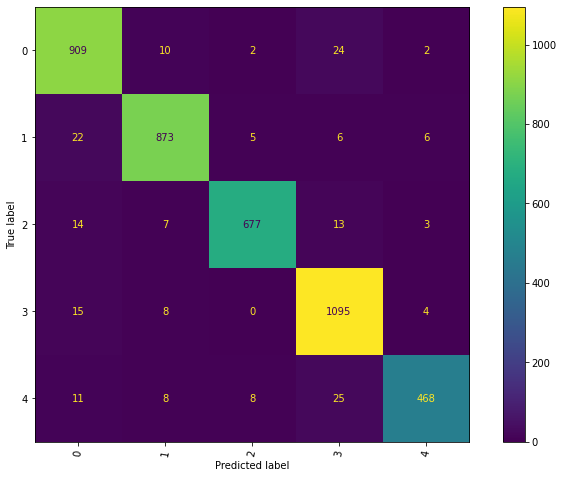

None


In [477]:
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)
mt=[]
print(display_classification_report(lr,mt))

## Decision Tree

In [478]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       947
           1       0.80      0.80      0.80       912
           2       0.79      0.84      0.81       714
           3       0.79      0.79      0.79      1122
           4       0.71      0.69      0.70       520

    accuracy                           0.77      4215
   macro avg       0.76      0.77      0.76      4215
weighted avg       0.77      0.77      0.77      4215



## Random Forest

In [479]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.82      0.68      0.75       947
           1       0.76      0.83      0.79       912
           2       0.89      0.77      0.82       714
           3       0.62      0.97      0.75      1122
           4       0.96      0.10      0.18       520

    accuracy                           0.73      4215
   macro avg       0.81      0.67      0.66      4215
weighted avg       0.78      0.73      0.70      4215



## Naive Bayes (optional)

In [480]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.49      0.34      0.40       947
           1       0.35      0.27      0.30       912
           2       0.52      0.50      0.51       714
           3       0.46      0.30      0.37      1122
           4       0.18      0.51      0.27       520

    accuracy                           0.36      4215
   macro avg       0.40      0.38      0.37      4215
weighted avg       0.42      0.36      0.37      4215



## We have seen that logistic regression is performing better as compared to other models 
## Now lets test it on a sample test data

In [481]:
# raw complaint data to be tested
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

test_complaints = pd.DataFrame({'complaints': ["I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue"]})

test_complaints

,complaints
0,I tried to make a transaction at a supermarket...


In [482]:
def predict_lr_performance(text):
    Topic_names = {0:'Bank account services', 1:'Others', 2:'Mortgages/loans', 3:'Credit card / Prepaid card', 4:'Theft/Dispute reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [484]:
test_complaints['tag'] = test_complaints['complaints'].apply(lambda x: predict_lr_performance([x]))
test_complaints

,complaints,tag
0,I tried to make a transaction at a supermarket...,Bank account services


## Conclusion
    
* **As expected 5 topics were indetified namely:**
    1. Bank account services
    2. Others
    3. Mortgages/loans
    4. Credit card / Prepaid card
    5. Theft/Dispute reporting

* **As expected 5 topics were indetified namely:**
####  Model                     Accuracy
### Logistic Regression 95
### Decision Tree       77
### Random Forest       73
### Naive Byes          36